In [2]:
# Автоматическая перезагрузка модулей при изменении
# Позволяет обновлять код в helper.py, plots.py, nlp.py без перезапуска ядра
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Импорт библиотек для классического ML и нейронных сетей
import pandas as pd
import numpy as np
import random

# Импорт sklearn для классических алгоритмов
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
from lightgbm import LGBMClassifier

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

# (опционально) ускорение/автосмешанная точность
from torch.cuda.amp import autocast, GradScaler

# Пользовательские модули
from helper import *        # вспомогательные функции
from plots import *         # функции визуализации
from nlp import *          # функции обработки естественного языка
from transformers import * # функции для работы с трансформерами
from pytorch_help import * # функции для работы с PyTorch

In [4]:
# Проверка GPU
if torch.cuda.is_available():
    n = torch.cuda.device_count()
    names = [torch.cuda.get_device_name(i) for i in range(n)]
    print(f"GPU доступен: {n} устройство(а/в): {names}")
    device = torch.device("cuda")
else:
    print("GPU недоступен, используется CPU")
    device = torch.device("cpu")


GPU недоступен, используется CPU


In [5]:
from pytorch_help import BiRNNClassifier, set_random_seed, TextCNNClassifier, BiLSTMClassifier, TextCNNGloveFrozen

In [6]:
# Фиксация состояния генератора псевдослучайных чисел для воспроизводимости
# Критически важно для машинного обучения - результаты должны быть воспроизводимы
SEED = 42 # можно указать любое число
np.random.seed(SEED)  # для numpy операций
random.seed(SEED)     # для стандартного модуля random
set_random_seed(SEED) # для PyTorch

In [7]:
# Загружаем предобработанные данные
df = pd.read_csv('data/data.csv')

## 1. Препроцессинг и бейслайн

**Цель:** Подготовить данные для обучения нейронных сетей и создать baseline модель для сравнения.
Нейронные сети требуют специальной предобработки - объединения текстов и создания последовательностей.

In [8]:
# Создаем копию данных для предобработки
df_preprocessed = df.copy()

# Токенизируем тексты
# Это необходимо для дальнейшей векторизации текстов
df_preprocessed['Title'] = df_preprocessed['Title'].apply(tokenize_words)
df_preprocessed['Description'] = df_preprocessed['Description'].apply(tokenize_words)

# Удаляем стоп-слова из токенов
for col in ['Description', 'Title']:
    df_preprocessed[col] = df_preprocessed[col].apply(
        lambda tokens: filter_tokens(
            tokens,
            remove_stopwords=True,
            to_lower=True
        )
    )

In [9]:
# Разделяем данные на признаки (X) и целевую переменную (y)
X, y = divide_data(df_preprocessed, 'Class Index')

In [10]:
# Создаем baseline модель LGBM для сравнения с нейронными сетями
lgbm_classifier = LGBMClassifier(random_state=SEED, verbose=-1)

In [11]:
# Настраиваем кросс-валидацию с 3 фолдами (меньше для ускорения обучения нейронных сетей)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

In [12]:
# Создаем пайплайн для векторизации текстов (для baseline модели)
count_vectorizer_preprocessor = Pipeline([
    ('vectorizer', ColumnTransformer(
        [
            ('title_vectorizer', CountVectorizer(analyzer=lambda x: x, min_df=10, dtype=np.float32), 'Title'),
            ('description_vectorizer', CountVectorizer(analyzer=lambda x: x, min_df=10, dtype=np.float32), 'Description'),
        ],
        remainder='drop', 
        verbose_feature_names_out=True
    )),
])

c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:26

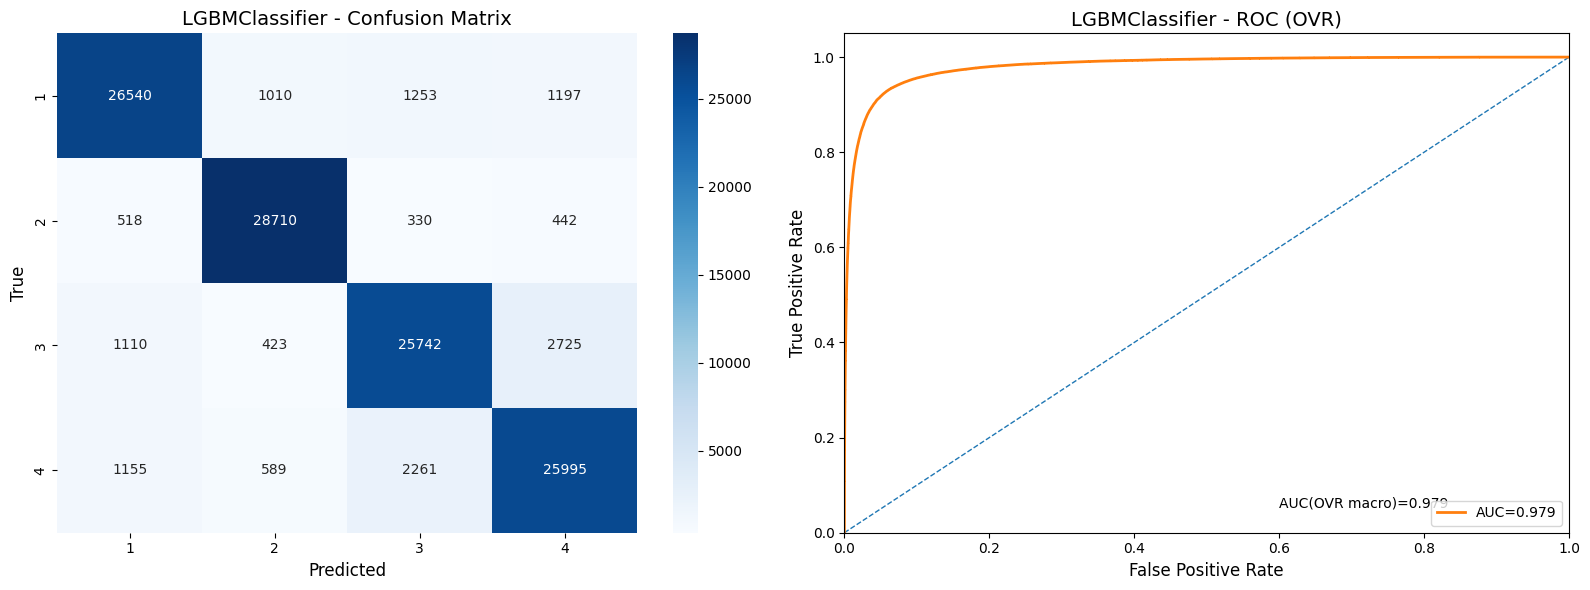

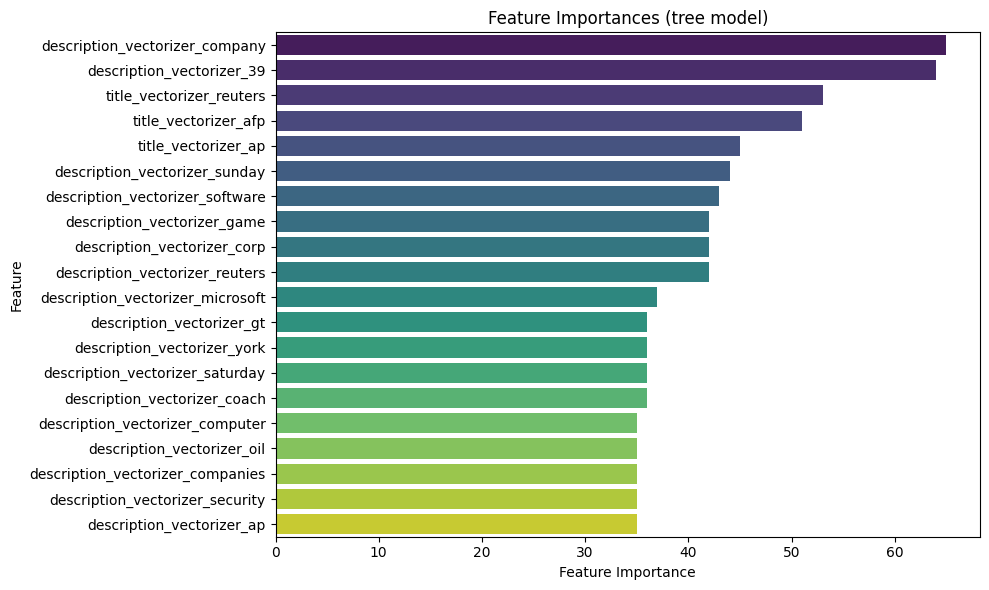

In [13]:
# Обучаем baseline модель LGBM для сравнения с нейронными сетями
baseline_metrics = train_evaluate_model_cv(
    model=lgbm_classifier,
    model_name='LGBMClassifier',
    X=X,
    y=y,
    preprocessor=count_vectorizer_preprocessor,
    cv=cv,
    seed=SEED
)


In [14]:
# Выводим метрики baseline модели
baseline_metrics.get_numeric_metrics()

{'ROC AUC': 0.9789793072222222,
 'F1 Score': 0.891402375056659,
 'Precision': 0.8914321759525595,
 'Recall': 0.8915583333333332,
 'Accuracy': 0.8915583333333333,
 'Training Time (s)': 18.312316417694092}

## Препроцессинг перед использованием нейросетей

**Цель:** Подготовить данные для нейронных сетей, которые работают с последовательностями токенов.
Нейронные сети не могут напрямую работать с несколькими отдельными текстами, поэтому объединяем их.

In [15]:
# Параметры для нейронных сетей
#MAX_NUM_WORDS = 100        # максимальное количество уникальных слов в словаре
MAX_SEQUENCE_LENGTH = 150  # максимальная длина последовательности токенов

In [16]:
# Нейронные сети не могут принимать на вход два разных вектора, поэтому объединяем их
# Конкатенируем заголовок и описание в один текст для создания единой последовательности
tokens_all = df_preprocessed["Title"] + df_preprocessed["Description"]  # списки токенов
X = tokens_all
y = df_preprocessed["Class Index"].astype(int).values - 1

In [17]:
# Демонстрация процесса предобработки для нейронных сетей
X_lol = list(X)

In [18]:
# Преобразуем токены в последовательности чисел для нейронных сетей
vect = SequenceVectorizer(min_freq=2, max_len=MAX_SEQUENCE_LENGTH, pad_left=False)
X_seq = vect.fit_transform(X_lol)

In [19]:
# Результат: каждая строка - это последовательность индексов токенов
# Длина каждой последовательности <= MAX_SEQUENCE_LENGTH (200)
X_seq

array([[  335,   336,  1457, ...,     0,     0,     0],
       [14517,   929,  1133, ...,     0,     0,     0],
       [   17,   263,  4338, ...,     0,     0,     0],
       ...,
       [ 7462,   529,  1261, ...,     0,     0,     0],
       [   47,     2,   600, ...,     0,     0,     0],
       [ 2027,  2244,  2839, ...,     0,     0,     0]],
      shape=(120000, 150), dtype=int32)

In [20]:
# Создаём препроцессор для нейронных сетей 
seq_vec = SequenceVectorizer(min_freq=2, max_len=MAX_SEQUENCE_LENGTH, pad_left=False)

# Преобразуем токены -> индексы (np.ndarray [N, L])
X_seq = seq_vec.fit_transform(X) 

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2. RNN (Рекуррентная нейронная сеть)

**Логика:** RNN обрабатывает последовательности токенов слева направо, сохраняя информацию о предыдущих токенах.
Используем Bidirectional RNN для анализа контекста в обе стороны. Это базовая архитектура для сравнения с более сложными.

In [22]:
X_t = torch.as_tensor(X_seq, dtype=torch.long)
y_t = torch.as_tensor(y, dtype=torch.long)


In [23]:
print(list(ClassificationMetrics.model_fields.keys()))
m = evaluate_classification(y[:100], y[:100], None, enable_plot=False)
print(m.f1_macro, m.precision_macro, m.recall_macro)

['name', 'training_time', 'estimators', 'accuracy', 'f1_macro', 'precision_macro', 'recall_macro', 'f1_weighted', 'precision_weighted', 'recall_weighted', 'roc_auc_ovr_macro', 'confusion_matrix', 'classification_report', 'roc_curve_micro', 'roc_curves_by_class', 'roc_auc', 'f1_score', 'precision', 'recall', 'roc_curve']
1.0 1.0 1.0


In [24]:
# Лучший AUC score: 0.979

# Гиперпараметры для RNN модели
#LEARNING_RATE = 1e-3
#BATCH_SIZE = 256   #256
#RNN_UNITS = 64          
#EMBEDDING_DIM = 64      
#DROPOUT_RATE = 0.3
#REGULARIZATION_STRENGTH = 1e-4     
#EPOCHS = 4   #4
#PATIENCE = 1 

LEARNING_RATE = 1e-3
BATCH_SIZE = 128   #256
RNN_UNITS = 128          
EMBEDDING_DIM = 128      
DROPOUT_RATE = 0.3
REGULARIZATION_STRENGTH = 1e-4     
EPOCHS = 8   
PATIENCE = 2  

#device = torch.device("cpu")

# Функция создания RNN модели
def build_rnn_model(vocab_size: int, device: torch.device):
    model = BiRNNClassifier(
        vocab_size=vocab_size,
        embed_dim=EMBEDDING_DIM,
        rnn_units=RNN_UNITS,
        num_classes=4,
        dropout=DROPOUT_RATE,
        pad_id=0
    )
    return model.to(device)

# Параметры обучения
fit_params = dict(
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LEARNING_RATE,
    weight_decay=REGULARIZATION_STRENGTH,
    early_stopping=dict(patience=PATIENCE, monitor="val_loss", mode="min"),
    verbose=1
)

# Обучаем RNN модель с кросс-валидацией
rnn_metrics = cross_validate_model(
    model_builder=lambda: build_rnn_model(vocab_size=int(np.max(X_seq))+1, device=device),
    X=X_seq,
    y=y,
    cv=cv,
    fit_params=fit_params
)

Fold 1
  epoch=1/8  val_loss=0.647147  best=0.647147  bad=0/2
  epoch=2/8  val_loss=0.458907  best=0.458907  bad=0/2
  epoch=3/8  val_loss=0.396651  best=0.396651  bad=0/2
  epoch=4/8  val_loss=0.350455  best=0.350455  bad=0/2
  epoch=5/8  val_loss=0.357234  best=0.350455  bad=1/2
  epoch=6/8  val_loss=0.348477  best=0.348477  bad=0/2
  epoch=7/8  val_loss=0.337987  best=0.337987  bad=0/2
  epoch=8/8  val_loss=0.364435  best=0.337987  bad=1/2
Fold 2
  epoch=1/8  val_loss=0.577865  best=0.577865  bad=0/2
  epoch=2/8  val_loss=0.441649  best=0.441649  bad=0/2
  epoch=3/8  val_loss=0.365358  best=0.365358  bad=0/2
  epoch=4/8  val_loss=0.333115  best=0.333115  bad=0/2
  epoch=5/8  val_loss=0.339716  best=0.333115  bad=1/2
  epoch=6/8  val_loss=0.346622  best=0.333115  bad=2/2
  EarlyStopping: stop on epoch 6, best_val=0.333115
Fold 3
  epoch=1/8  val_loss=0.605010  best=0.605010  bad=0/2
  epoch=2/8  val_loss=0.435452  best=0.435452  bad=0/2
  epoch=3/8  val_loss=0.384396  best=0.384396  

In [25]:
# Результаты обучения RNN модели
rnn_metrics.get_numeric_metrics()

{'ROC AUC': 0.9733524423611111,
 'F1 Score': 0.8944142465540393,
 'Precision': 0.8953281183391081,
 'Recall': 0.8945083333333335,
 'Accuracy': 0.8945083333333333,
 'Training Time (s)': 5007.7129671998555}

## 3. CNN (Сверточная нейронная сеть)

**Логика:** CNN применяет сверточные фильтры к последовательности токенов, выявляя локальные паттерны.
GlobalMaxPooling1D выбирает наиболее важные признаки из всей последовательности.
CNN часто работают быстрее RNN и могут выявлять n-граммы эффективнее.

In [26]:
# Гиперпараметры для CNN модели
LEARNING_RATE = 1e-3
BATCH_SIZE = 128  #256
EMBEDDING_DIM = 128
FILTERS = 128
KERNEL_SIZE = 3
DROPOUT_RATE = 0.3
WEIGHT_DECAY = 1e-4     
EPOCHS = 4  #8
PATIENCE = 2

# Функция создания CNN модели
def build_cnn_model(vocab_size: int, device: torch.device):
    model = TextCNNClassifier(
        vocab_size=vocab_size,
        embed_dim=EMBEDDING_DIM,
        num_filters=FILTERS,
        kernel_size=KERNEL_SIZE,
        num_classes=4,
        dropout=DROPOUT_RATE,
        pad_id=0,
    )
    return model.to(device)

# vocab_size безопасно брать так (без офф-бай-ванов)
vocab_size = int(np.max(X_seq)) + 1

fit_params = dict(
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    device=device,
    early_stopping=dict(patience=PATIENCE, monitor="val_loss", mode="min"),
    verbose=1,
)

cnn_metrics = cross_validate_model(
    model_builder=lambda: build_cnn_model(vocab_size=vocab_size, device=device),
    X=X_seq,
    y=y,
    cv=cv,
    fit_params=fit_params,
    preprocessor=None,
)


Fold 1
  epoch=1/4  val_loss=0.459763  best=0.459763  bad=0/2
  epoch=2/4  val_loss=0.372605  best=0.372605  bad=0/2
  epoch=3/4  val_loss=0.329191  best=0.329191  bad=0/2
  epoch=4/4  val_loss=0.301566  best=0.301566  bad=0/2
Fold 2
  epoch=1/4  val_loss=0.452932  best=0.452932  bad=0/2
  epoch=2/4  val_loss=0.364140  best=0.364140  bad=0/2
  epoch=3/4  val_loss=0.322316  best=0.322316  bad=0/2
  epoch=4/4  val_loss=0.299035  best=0.299035  bad=0/2
Fold 3
  epoch=1/4  val_loss=0.465962  best=0.465962  bad=0/2
  epoch=2/4  val_loss=0.380236  best=0.380236  bad=0/2
  epoch=3/4  val_loss=0.335117  best=0.335117  bad=0/2
  epoch=4/4  val_loss=0.304960  best=0.304960  bad=0/2
Nothing to plot: confusion_matrix and ROC curves are missing.


In [27]:
# Результаты обучения CNN модели
cnn_metrics


ClassificationMetrics(name='PyTorch CV', training_time=218.76104150002357, estimators=[{'preprocessor': None, 'model': TextCNNClassifier(
  (embed): Embedding(43811, 128, padding_idx=0)
  (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=4, bias=True)
), 'optimizer': 'Adam', 'epochs': 4, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0001, 'early_stopping': {'patience': 2, 'monitor': 'val_loss', 'mode': 'min'}}, {'preprocessor': None, 'model': TextCNNClassifier(
  (embed): Embedding(43811, 128, padding_idx=0)
  (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=4, bias=True)
), 'optimizer': 'Adam', 'epochs': 4, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0001, 'early_stopping': {'patience': 2, 'monitor': 'val_loss', 'mode': 'min'}}, {'preprocessor': None, 'model': TextCNNClassifier(
  (embed):

In [28]:
# Гиперпараметры для LSTM модели
LEARNING_RATE = 1e-3
BATCH_SIZE = 64  #256
EMBEDDING_DIM = 128
LSTM_UNITS = 128
DROPOUT_RATE = 0.3
WEIGHT_DECAY = 1e-4
EPOCHS = 3 #8
PATIENCE = 2

# Функция создания LSTM модели
def build_lstm_model(vocab_size: int, device: torch.device):
    model = BiLSTMClassifier(
        vocab_size=vocab_size,
        embed_dim=EMBEDDING_DIM,
        hidden_size=LSTM_UNITS,
        num_classes=4,
        dropout=DROPOUT_RATE,
        pad_id=0,
    )
    return model.to(device)

vocab_size = int(np.max(X_seq)) + 1

fit_params = dict(
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    device=device,
    early_stopping=dict(patience=PATIENCE, monitor="val_loss", mode="min"),
    verbose=1
)

lstm_metrics = cross_validate_model(
    model_builder=lambda: build_lstm_model(vocab_size=vocab_size, device=device),
    X=X_seq,
    y=y,
    cv=cv,
    fit_params=fit_params,
    preprocessor=None,
)

Fold 1
  epoch=1/3  val_loss=0.379173  best=0.379173  bad=0/2
  epoch=2/3  val_loss=0.317422  best=0.317422  bad=0/2
  epoch=3/3  val_loss=0.288949  best=0.288949  bad=0/2
Fold 2
  epoch=1/3  val_loss=0.376349  best=0.376349  bad=0/2
  epoch=2/3  val_loss=0.303477  best=0.303477  bad=0/2
  epoch=3/3  val_loss=0.282573  best=0.282573  bad=0/2
Fold 3
  epoch=1/3  val_loss=0.387629  best=0.387629  bad=0/2
  epoch=2/3  val_loss=0.300517  best=0.300517  bad=0/2
  epoch=3/3  val_loss=0.293345  best=0.293345  bad=0/2
Nothing to plot: confusion_matrix and ROC curves are missing.


In [29]:
# Результаты обучения LSTM модели
lstm_metrics.get_numeric_metrics()


{'ROC AUC': 0.9831003584722223,
 'F1 Score': 0.9046646344612537,
 'Precision': 0.9060291513121493,
 'Recall': 0.9047000000000001,
 'Accuracy': 0.9047000000000001,
 'Training Time (s)': 6997.7832382998895}

In [30]:
from pathlib import Path

ROOT = Path.cwd()  # если ноутбук запущен из корня репо (где helper.py)
GLOVE_PATH = ROOT / "embenddings" / "glove.6B.100d.txt"  # ВАЖНО: embenddings

print("GLOVE_PATH =", GLOVE_PATH)

GLOVE_PATH = c:\Users\Nocomp\Desktop\News NN\embenddings\glove.6B.100d.txt


In [31]:
# ===== 1) Load glove vocab+matrix (у тебя уже есть _load_glove_fixed_vocab) =====
GLOVE_DIM = 100
GLOVE_MAX_VOCAB = 20000
#GLOVE_PATH = "embeddings/glove.6B.100d.txt"


def _load_glove_fixed_vocab(path: str, embedding_dim: int, max_words: int) -> Tuple[dict, np.ndarray]:
    """Загружает GloVe эмбеддинги и создает словарь с фиксированным размером"""
    vocab: Dict[str, int] = {'<PAD>': 0, '<OOV>': 1}  # специальные токены
    matrix = [np.zeros(embedding_dim, dtype='float32'), np.zeros(embedding_dim, dtype='float32')]

    added = 0
    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            if added >= max_words:
                break
            parts = line.rstrip().split(' ')
            if len(parts) < embedding_dim + 1:
                continue
            token = parts[0]
            if token in vocab:  # пропускаем дубликаты
                continue
            vec = np.asarray(parts[1:], dtype='float32')
            if vec.shape[0] != embedding_dim:
                continue
            # присваиваем следующий ID начиная с 2
            idx = len(vocab)
            vocab[token] = idx
            matrix.append(vec)
            added += 1

    embedding_matrix = np.vstack(matrix)
    return vocab, embedding_matrix

# Загружаем GloVe эмбеддинги
glove_vocab, glove_matrix = _load_glove_fixed_vocab(GLOVE_PATH, GLOVE_DIM, GLOVE_MAX_VOCAB)

PAD_ID = 0
OOV_ID = 1

def tokens_to_ids_fixed_vocab(
    tokens_list,
    vocab: dict,
    max_len: int = 250,
    pad_left: bool = False,
):
    X_ids = np.full((len(tokens_list), max_len), PAD_ID, dtype=np.int32)
    for i, toks in enumerate(tokens_list):
        ids = [vocab.get(t, OOV_ID) for t in toks]
        ids = ids[:max_len]
        if pad_left:
            X_ids[i, -len(ids):] = ids
        else:
            X_ids[i, :len(ids)] = ids
    return X_ids

X_glove_seq = tokens_to_ids_fixed_vocab(X, glove_vocab, max_len=MAX_SEQUENCE_LENGTH, pad_left=False)

LEARNING_RATE = 1e-3
BATCH_SIZE = 256 #256
FILTERS = 128
KERNEL_SIZE = 3
DROPOUT_RATE = 0.3
WEIGHT_DECAY = 1e-4
EPOCHS = 6 #8
PATIENCE = 2


def build_cnn_glove_frozen_model():
    return TextCNNGloveFrozen(
        glove_weights=glove_matrix.astype(np.float32),
        num_filters=FILTERS,
        kernel_size=KERNEL_SIZE,
        num_classes=4,
        dropout=DROPOUT_RATE,
        pad_id=0
    ).to(device)

fit_params = dict(
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    device=device,
    early_stopping=dict(patience=PATIENCE, monitor="val_loss", mode="min"),
    verbose=1,
)

cnn_glove_fixed_metrics = cross_validate_model(
    model_builder=build_cnn_glove_frozen_model,
    X=X_glove_seq,
    y=y,
    cv=cv,
    fit_params=fit_params,
    preprocessor=None,
)


Fold 1
  epoch=1/6  val_loss=0.327823  best=0.327823  bad=0/2
  epoch=2/6  val_loss=0.307572  best=0.307572  bad=0/2
  epoch=3/6  val_loss=0.295558  best=0.295558  bad=0/2
  epoch=4/6  val_loss=0.285936  best=0.285936  bad=0/2
  epoch=5/6  val_loss=0.284806  best=0.284806  bad=0/2
  epoch=6/6  val_loss=0.276465  best=0.276465  bad=0/2
Fold 2
  epoch=1/6  val_loss=0.323600  best=0.323600  bad=0/2
  epoch=2/6  val_loss=0.298443  best=0.298443  bad=0/2
  epoch=3/6  val_loss=0.288906  best=0.288906  bad=0/2
  epoch=4/6  val_loss=0.288387  best=0.288387  bad=0/2
  epoch=5/6  val_loss=0.281704  best=0.281704  bad=0/2
  epoch=6/6  val_loss=0.281386  best=0.281386  bad=0/2
Fold 3
  epoch=1/6  val_loss=0.326790  best=0.326790  bad=0/2
  epoch=2/6  val_loss=0.306370  best=0.306370  bad=0/2
  epoch=3/6  val_loss=0.293942  best=0.293942  bad=0/2
  epoch=4/6  val_loss=0.288212  best=0.288212  bad=0/2
  epoch=5/6  val_loss=0.284631  best=0.284631  bad=0/2
  epoch=6/6  val_loss=0.279561  best=0.27956

In [32]:
rnn_metrics.name = "RNN"
cnn_metrics.name = "CNN"
lstm_metrics.name = "LSTM"
cnn_glove_fixed_metrics.name = "CNN + GloVe (frozen)"
baseline_metrics.name = "LGBM"

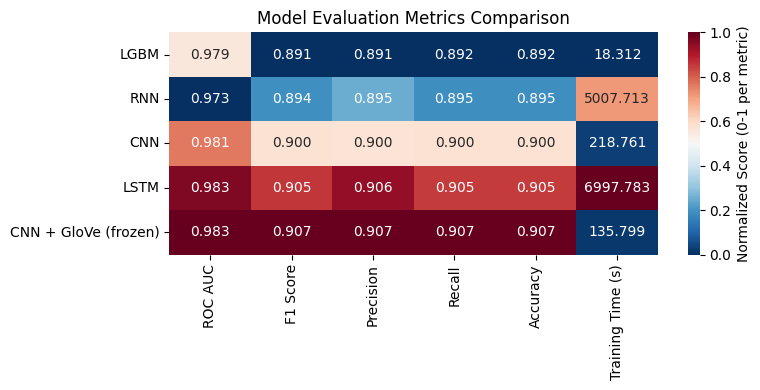

In [33]:
# Сравниваем результаты всех обученных моделей
# Тепловая карта покажет, какая модель показала наилучшие результаты
plot_metrics_heatmap(
    metrics=[
        baseline_metrics,      # LGBM baseline
        rnn_metrics,          # RNN нейронная сеть
        cnn_metrics,          # CNN нейронная сеть
        lstm_metrics,         # LSTM нейронная сеть
        cnn_glove_fixed_metrics  # CNN с предобученными GloVe эмбеддингами
    ],
)